In [1]:
%load_ext autoreload
%autoreload 2

from dotenv import load_dotenv
import pandas as pd
import numpy as np
import os
import sys
import sqlalchemy as sa

root_path = os.path.abspath(os.path.join('..'))
if root_path not in sys.path:
    sys.path.append(root_path)
    

load_dotenv()

True

In [2]:
from keras.models import load_model

model_view = load_model('../model/d-view.keras')
model_cart = load_model('../model/d-cart.keras')
model_remove_from_cart = load_model('../model/d-remove_from_cart.keras')
model_purchase = load_model('../model/d-purchase.keras')

In [3]:
conn_string = 'postgresql://{db_user}:{db_password}@{db_host}:{db_port}/cosmetic'.format(
    db_user=os.getenv('DB_USER'),
    db_password=os.getenv('DB_PASSWORD'),
    db_host=os.getenv('DB_HOST'),
    db_port=os.getenv('DB_PORT'),
)
engine = sa.create_engine(conn_string)

In [4]:
import datetime

start = datetime.date(2020, 2, 15)
end = datetime.date(2020, 3, 1)

In [5]:
def df_to_X_y(df: pd.DataFrame):
    df_as_np = df.to_numpy()
    X = df_as_np[:, 6:]
    y = df_as_np[:, 2:6]
    return X, y


In [6]:
from collections import defaultdict
from sqlalchemy import orm

from schemas.product import Product
from schemas.data_by_date import DataByDate
from training.utils import date_range

prev_days = int(os.getenv('PREV_DAYS'))

with orm.Session(engine) as session, session.begin():
    products = dict[tuple[int, int], Product]()
    for row in session.scalars(sa.select(Product)).all():
        products[(row.product_id, row.category_id)] = row
    
    memorized = defaultdict(lambda: defaultdict(lambda: { 'view': 0, 'cart': 0, 'remove_from_cart': 0, 'purchase': 0 }))

    d = start - datetime.timedelta(days=prev_days)
    for i in range(prev_days):
        for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
            key = (row.product_id, row.category_id)
            memorized[d][key] = {
                'view': row.view,
                'cart': row.cart,
                'remove_from_cart': row.remove_from_cart,
                'purchase': row.purchase,
            }

        d += datetime.timedelta(days=1)
    
    while d < end:
        records = list[dict]()

        rows = list[dict]()
        categories = defaultdict(lambda: list[dict]())
        for row in session.scalars(sa.select(DataByDate).where(DataByDate.date == d).order_by(DataByDate.rank.asc())):
            key = (row.product_id, row.category_id)
            record = {
                'product_id': row.product_id,
                'category_id': row.category_id,
                'view': row.view,
                'cart': row.cart,
                'remove_from_cart': row.remove_from_cart,
                'purchase': row.purchase,
                'rank': row.rank,
                'rank_in_category': row.rank_in_category,
                'days_on_shelf': (d - products[key].release_date).days,
                'price': row.max_price,
            }

            rows.append(record)
            categories[row.category_id].append(record)

        
        def key_func(record: dict):
            key = (record['product_id'], record['category_id'])
            prev_sales = 0
            for p in date_range(d - datetime.timedelta(days=30), d, datetime.timedelta(days=1)):
                prev_sales += memorized[p][key]['purchase']
            return -prev_sales, record['days_on_shelf'], record['price']
        
        # for category in categories.values():
        #     category.sort(key=key_func)
        #     for index, record in enumerate(category):
        #         record['rank_in_category'] = index + 1

        # rows.sort(key=key_func)      
        
        for index, record in enumerate(rows):
            key = (record['product_id'], record['category_id'])

            # record['rank_in_category'] = index + 1

            for i in range(1, prev_days + 1):
                prev_d = d - datetime.timedelta(days=i)
                record[f'view_prev{i}'] = memorized[prev_d][key]['view']
                record[f'cart_prev{i}'] = memorized[prev_d][key]['cart']
                record[f'remove_from_cart_prev{i}'] = memorized[prev_d][key]['remove_from_cart']
                record[f'purchase_prev{i}'] = memorized[prev_d][key]['purchase']

            release_date = products[key].release_date
            if (d - products[key].release_date).days >= 7:
                records.append(record)
            else:
                memorized[d][key] = {
                    'view': record['view'],
                    'cart': record['cart'],
                    'remove_from_cart': record['remove_from_cart'],
                    'purchase': record['purchase'],
                }
        
        del memorized[d - datetime.timedelta(days=prev_days)]

        df = pd.DataFrame.from_records(records)
        X, y = df_to_X_y(df)
        df['predicted_view'] = model_view.predict(X)[:, 0]
        df['predicted_cart'] = model_cart.predict(X)[:, 0]
        df['predicted_remove_from_cart'] = model_remove_from_cart.predict(X)[:, 0]
        df['predicted_purchase'] = model_purchase.predict(X)[:, 0]

        result_df = df[[
            'product_id', 
            'category_id', 
            'rank',
            'rank_in_category',
            'view', 
            'predicted_view', 
            'cart', 
            'predicted_cart', 
            'remove_from_cart', 
            'predicted_remove_from_cart', 
            'purchase', 
            'predicted_purchase'
        ]]
        name = d.strftime('%Y-%m-%d')
        result_df.to_csv(f'../.data/predict/d-{name}.csv')
        for result in result_df.to_dict('records'):
            key = (result['product_id'], result['category_id'])
            memorized[d][key] = {
                'view': result['predicted_view'],
                'cart': result['predicted_cart'],
                'remove_from_cart': result['predicted_remove_from_cart'],
                'purchase': result['predicted_purchase'],
            }

        d += datetime.timedelta(days=1)        

700/700 [==============================] - 1s 1ms/step


In [7]:
df

,product_id,category_id,view,cart,remove_from_cart,purchase,rank,rank_in_category,days_on_shelf,price,...,remove_from_cart_prev29,purchase_prev29,view_prev30,cart_prev30,remove_from_cart_prev30,purchase_prev30,predicted_view,predicted_cart,predicted_remove_from_cart,predicted_purchase
0,5809910,1602943681873052386,642,164,77,49,1,1,151,5.24,...,91,51,754,202,130,39,554.723816,208.299835,133.203659,57.340534
1,5854897,1487580009445982239,48,176,59,34,2,1,151,0.32,...,81,32,120,262,37,32,1.167791,117.933311,38.016342,22.445261
2,5700037,1487580009286598681,67,128,28,10,3,1,151,0.40,...,41,24,110,139,29,24,9.752593,129.784943,51.081993,22.591473
3,5802432,1487580009286598681,66,151,51,25,4,2,151,0.32,...,43,10,14,43,28,3,1.167791,101.861183,39.463730,18.309746
4,5815662,1487580006317032337,81,121,38,26,5,1,151,0.92,...,62,14,122,131,36,17,36.249466,88.284668,46.949329,19.150490
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22387,5930158,1487580007675986893,0,1,0,0,22487,1408,7,1.43,...,0,0,0,0,0,0,1.167791,0.736404,0.459518,0.149136
22388,5930677,1487580007675986893,0,0,2,0,22488,1409,7,1.43,...,0,0,0,0,0,0,1.167791,0.736404,0.514708,0.149136
22389,5930761,1487580007675986893,0,0,3,0,22489,1410,7,1.43,...,0,0,0,0,0,0,1.167791,0.736404,0.641132,0.149136
22390,5930766,1487580007675986893,0,0,2,0,22490,1411,7,1.43,...,0,0,0,0,0,0,1.167791,0.736404,0.529864,0.149136


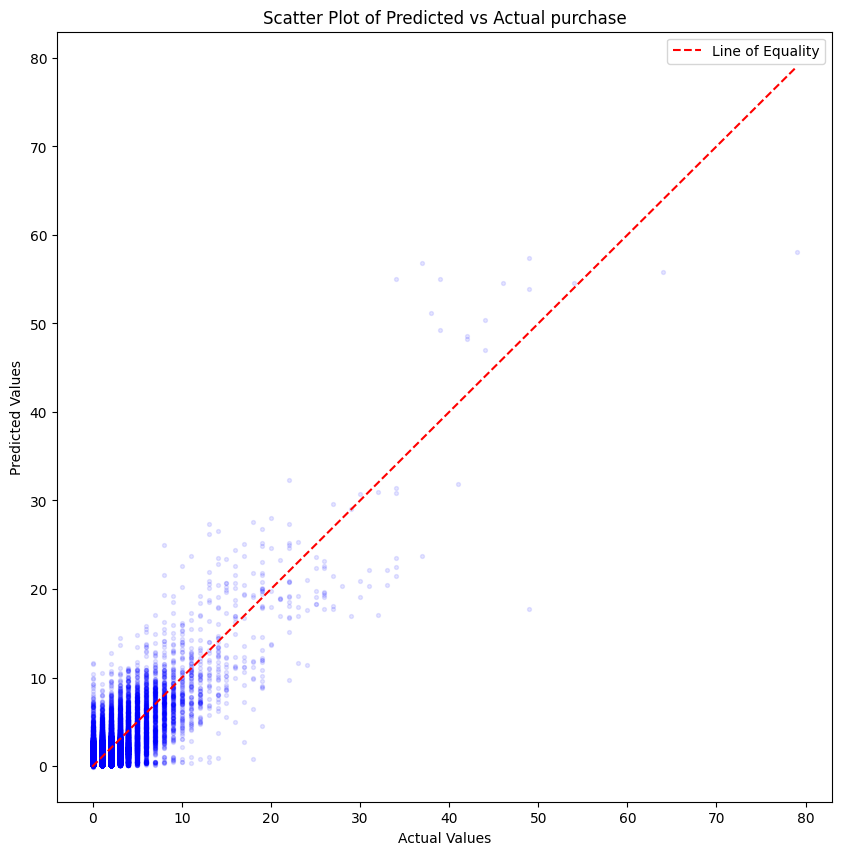

,Unnamed: 0,product_id,category_id,rank,rank_in_category,view,predicted_view,cart,predicted_cart,remove_from_cart,predicted_remove_from_cart,purchase,predicted_purchase
0,0,5809910,1602943681873052386,1,1,516,589.290040,153,178.286250,72,110.005790,44,46.982315
1,1,5854897,1487580009445982239,2,1,51,28.077320,158,157.111850,44,64.146740,22,32.369140
2,2,5809912,1602943681873052386,3,2,140,183.691650,68,81.585500,46,59.828667,19,21.533089
3,3,5700037,1487580009286598681,4,1,70,60.655130,182,165.369320,32,58.845910,19,25.171970
4,4,5751422,1487580005268456287,5,1,93,99.337530,51,65.479850,29,38.099150,8,19.321320
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22387,22387,5930158,1487580007675986893,22487,1408,0,1.167791,1,0.736404,0,0.459518,0,0.149136
22388,22388,5930677,1487580007675986893,22488,1409,0,1.167791,0,0.736404,2,0.514708,0,0.149136
22389,22389,5930761,1487580007675986893,22489,1410,0,1.167791,0,0.736404,3,0.641131,0,0.149136
22390,22390,5930766,1487580007675986893,22490,1411,0,1.167791,0,0.736404,2,0.529864,0,0.149136


In [8]:
from training.utils import plot_accuracy

result_df = pd.concat([
    pd.read_csv(f'../.data/predict/d-{d.strftime("%Y-%m-%d")}.csv') for d in date_range(start, end, datetime.timedelta(days=1))
])


plot_accuracy(result_df['predicted_purchase'], result_df['purchase'], 'purchase')
result_df